# Capstone Project - The Battle of the Neighborhoods

## Introduction: Business Problem

In this project we will try to find an optimal location for a restaurant. Specifically, this report will be targeted to stakeholders interested in opening a Japanese restaurant in Toronto, Canada.

Since there are lots of restaurants in Toronto we will try to detect locations that are not already crowded with restaurants. We are also particularly interested in areas with no Japanese restaurants in vicinity. 

We will use our data science powers to generate a few most promising neighborhoods based on this criteria. Advantages of each area will then be clearly expressed so that best possible final location can be chosen by stakeholders.

## Data

In this project, I will find out the best neighborhood in Toronto for entrepreneurs to open a new Japanese Restaurant by:

- Using multiple datasets from different sources (i.e. Web, Foursquare API)
- Python Webscraping using Beautifulsoup
- Data Preprocessing
- Data Analysis

## Install and Import Libraries Necessary

In [2]:
!pip install BeautifulSoup4
!pip install lxml
!pip install geocoder
!pip install seaborn
!pip install wordcloud
!pip install sklearn --upgrade
!pip install folium --upgrade


import pandas as pd
from bs4 import BeautifulSoup
import requests ## Used to make requisitions
import geocoder ## Used to capture latitude e longitude from location
import numpy as np
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import folium

import warnings
warnings.filterwarnings('ignore')

     |████████████████████████████████| 122kB 1.0MB/s eta 0:00:01
     |████████████████████████████████| 102kB 18.2MB/s ta 0:00:01
     |████████████████████████████████| 368kB 30.6MB/s eta 0:00:01
  Stored in directory: /home/jupyterlab/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn
     |████████████████████████████████| 102kB 22.3MB/s ta 0:00:01
  Found existing installation: folium 0.5.0
    Uninstalling folium-0.5.0:
      Successfully uninstalled folium-0.5.0


## Obtain Toronto data

In [3]:
# fetching Wikipedia page data using requests
data = requests.get('https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M').text

In [4]:
# parsing data using BeautifulSoup
soup = BeautifulSoup(data, 'html.parser')

In [5]:
table_contents=[]
table=soup.find('table')
for row in table.findAll('td'):
    cell = {}
    if row.span.text=='Not assigned':
        pass
    else:
        cell['PostalCode'] = row.p.text[:3]
        cell['Borough'] = (row.span.text).split('(')[0]
        cell['Neighborhood'] = (((((row.span.text).split('(')[1]).strip(')')).replace(' /',',')).replace(')',' ')).strip(' ')
        table_contents.append(cell)

# print(table_contents)
df_Toronto=pd.DataFrame(table_contents)
df_Toronto['Borough']=df_Toronto['Borough'].replace({'Downtown TorontoStn A PO Boxes25 The Esplanade':'Downtown Toronto Stn A',
                                             'East TorontoBusiness reply mail Processing Centre969 Eastern':'East Toronto Business',
                                             'EtobicokeNorthwest':'Etobicoke Northwest','East YorkEast Toronto':'East York/East Toronto',
                                             'MississaugaCanada Post Gateway Processing Centre':'Mississauga'})

In [6]:
df_Toronto.head(10)

,PostalCode,Borough,Neighborhood
0,M3A,North York,Parkwoods
1,M4A,North York,Victoria Village
2,M5A,Downtown Toronto,"Regent Park, Harbourfront"
3,M6A,North York,"Lawrence Manor, Lawrence Heights"
4,M7A,Queen's Park,Ontario Provincial Government
5,M9A,Etobicoke,Islington Avenue
6,M1B,Scarborough,"Malvern, Rouge"
7,M3B,North York,Don Mills North
8,M4B,East York,"Parkview Hill, Woodbine Gardens"
9,M5B,Downtown Toronto,"Garden District, Ryerson"


In [7]:
# using the Geospatial_Coordinates.csv to get respective coordinates for each postal code
import csv
df_geo_coor = pd.read_csv('https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMDeveloperSkillsNetwork-DS0701EN-SkillsNetwork/labs_v1/Geospatial_Coordinates.csv')
df_geo_coor.head()

,Postal Code,Latitude,Longitude
0,M1B,43.806686,-79.194353
1,M1C,43.784535,-79.160497
2,M1E,43.763573,-79.188711
3,M1G,43.770992,-79.216917
4,M1H,43.773136,-79.239476


In [8]:
# merging both datasets together
df_toronto = pd.merge(df_Toronto, df_geo_coor, how='left', left_on = 'PostalCode', right_on = 'Postal Code')

# remove the "Postal Code" column
df_toronto.drop("Postal Code", axis=1, inplace=True)
df_toronto.head()

,PostalCode,Borough,Neighborhood,Latitude,Longitude
0,M3A,North York,Parkwoods,43.753259,-79.329656
1,M4A,North York,Victoria Village,43.725882,-79.315572
2,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,M6A,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,M7A,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [9]:
# remove the "PostalCode" column
df_toronto.drop("PostalCode", axis=1, inplace=True)
df_toronto.head()

,Borough,Neighborhood,Latitude,Longitude
0,North York,Parkwoods,43.753259,-79.329656
1,North York,Victoria Village,43.725882,-79.315572
2,Downtown Toronto,"Regent Park, Harbourfront",43.654260,-79.360636
3,North York,"Lawrence Manor, Lawrence Heights",43.718518,-79.464763
4,Queen's Park,Ontario Provincial Government,43.662301,-79.389494


In [10]:
! pip install geopy 
from geopy.geocoders import Nominatim # convert an address into longitude and latitude values 

     |████████████████████████████████| 122kB 990kB/s eta 0:00:01


In [11]:
# getting the latitude and longitude of Toronto
address = "Toronto, ON"

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Toronto city are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Toronto city are 43.6534817, -79.3839347.


In [12]:
# creating map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)
map_toronto

In [13]:
# adding in the markers for Toronto neighborhoods
for lat, lng, borough, neighborhood in zip(
        df_toronto['Latitude'], 
        df_toronto['Longitude'], 
        df_toronto['Borough'], 
        df_toronto['Neighborhood']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  

map_toronto

## Defining Foursquare credentials

In [14]:
CLIENT_ID = 'SC1ZMIKRAT4EVGKG5HMHZLHJAAW04YYZF2FDMWKHOBEWEHE5' # your Foursquare ID
CLIENT_SECRET = 'VZWXXIDURYJAMI3AA1XLJAX4J5I2ZPRSA4XLJSGK5BQNNXT1' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

In [15]:
# scraping the foursquare website for the information we want and obtaining the json file as results
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    CLIENT_ID, 
    CLIENT_SECRET, 
    VERSION, 
    latitude, 
    longitude, 
    radius, 
    LIMIT)

# get the result to a json file
results = requests.get(url).json()

In [16]:
## Function capture Latitude and Longitue from Neighborhood

def get_latlng (neighborhood):
  
  lat_lng_coords = None 
  while (lat_lng_coords is None): 
      g = geocoder.arcgis (LOCATION_SPEC.format (neighborhood)) 
      lat_lng_coords = g.latlng 
  return lat_lng_coords

## Function capture details venue with API Foursquare

def get_venues(lat,lng):
    
  #set variables
  radius = 3000
  LIMIT = 100
  
  #url to fetch data from foursquare api
  url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
          CLIENT_ID, 
          CLIENT_SECRET, 
          VERSION, 
          lat, 
          lng, 
          radius, 
          LIMIT)
  
  # get all the data
  results = requests.get(url).json()
  venue_data = results["response"]['groups'][0]['items']
  venue_details = []
  for row in venue_data:
      try:
          venue_id = row['venue']['id']
          venue_name = row['venue']['name']
          venue_category = row['venue']['categories'][0]['name']
          venue_origin = row['venue']['categories'][0]['shortName']
          venue_latitude = row['venue']['location']['lat']
          venue_longitude = row['venue']['location']['lng']
          venue_details.append([venue_id, venue_name, venue_category, venue_origin, venue_latitude, venue_longitude])
      except KeyError:
          pass
      
  column_names=['ID', 'Name', 'Category', 'Origin', 'Latitude', 'Longitude']
  df = pd.DataFrame(venue_details, columns = column_names)
  print("done!")
  return df

def get_info(id):

  #url to fetch data from foursquare api
  url = 'https://api.foursquare.com/v2/venues/{}?&client_id={}&v={}&client_secret={}'.format(
          id,
          CLIENT_ID, 
          VERSION, 
          CLIENT_SECRET)

  # get all the data
  result = requests.get(url).json()
  venue_info = result['response']

  return venue_info
  
def return_most_common_venues(row, num_top_venues):

  row_categories = row.iloc[1:]
  row_categories_sorted = row_categories.sort_values(ascending = False)

  return row_categories_sorted.index.values[0:num_top_venues]

## Searching for Restaurants

In [17]:
target = 'Restaurant'
columns_names = ['Neighborhood', 'ID', 'Name', 'Latitude', 'Longitude']
restaurants_toronto = pd.DataFrame(columns = columns_names)
count=1

for row in df_toronto.values.tolist():
  Borough, Neighborhood, Latitude, Longitude = row
  venues = get_venues(Latitude, Longitude)
  ##restaurants = venues[venues['Category'] == target]
  restaurants = venues[venues['Category'].str.contains(target)]
  print('(',count,'/',len(df_toronto),')', 
        target + ' in ' + 
        Neighborhood + ': ' + 
        str(len(restaurants)))
  
  for detail in restaurants.values.tolist():
    id, name, category, food, lat, lng = detail
    restaurants_toronto = restaurants_toronto.append({
        'Neighborhood':Neighborhood, 'ID':id, 'Name':name, 
        'Category':category, 'Food':food, 
        'Latitude':lat, 'Longitude':lng}, ignore_index = True)
  count += 1

done!
( 1 / 103 ) Restaurant in Parkwoods: 42
done!
( 2 / 103 ) Restaurant in Victoria Village: 33
done!
( 3 / 103 ) Restaurant in Regent Park, Harbourfront: 20
done!
( 4 / 103 ) Restaurant in Lawrence Manor, Lawrence Heights: 25
done!
( 5 / 103 ) Restaurant in Ontario Provincial Government: 23
done!
( 6 / 103 ) Restaurant in Islington Avenue: 24
done!
( 7 / 103 ) Restaurant in Malvern, Rouge: 11
done!
( 8 / 103 ) Restaurant in Don Mills North: 27
done!
( 9 / 103 ) Restaurant in Parkview Hill, Woodbine Gardens: 21
done!
( 10 / 103 ) Restaurant in Garden District, Ryerson: 21
done!
( 11 / 103 ) Restaurant in Glencairn: 27
done!
( 12 / 103 ) Restaurant in West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale: 10
done!
( 13 / 103 ) Restaurant in Rouge Hill, Port Union, Highland Creek: 7
done!
( 14 / 103 ) Restaurant in Don Mills South: 24
done!
( 15 / 103 ) Restaurant in Woodbine Heights: 28
done!
( 16 / 103 ) Restaurant in St. James Town: 18
done!
( 17 / 103 ) Restaurant

## Checking Datas - All Restaurants

In [18]:
restaurants_toronto = restaurants_toronto.drop_duplicates(subset=['ID']).reset_index(drop = True) ## Remove items ID duplicates and reset index
restaurants_toronto

,Neighborhood,ID,Name,Latitude,Longitude,Category,Food
0,Parkwoods,4b8991cbf964a520814232e3,Allwyn's Bakery,43.759840,-79.324719,Caribbean Restaurant,Caribbean
1,Parkwoods,4b0aed06f964a520202a23e3,Island Foods,43.745866,-79.346035,Caribbean Restaurant,Caribbean
2,Parkwoods,4b149ea4f964a52029a523e3,Darband Restaurant,43.755194,-79.348498,Middle Eastern Restaurant,Middle Eastern
3,Parkwoods,519e5c39498eb25c945e98c8,VIA CIBO | italian streetfood,43.754067,-79.357951,Italian Restaurant,Italian
4,Parkwoods,54b55e81498e6b087da5f439,Me Va Me Kitchen Express,43.754957,-79.351894,Mediterranean Restaurant,Mediterranean
...,...,...,...,...,...,...,...
878,Enclave of M4L,4bc37b7c920eb713b4851d2c,Ruby WatchCo.,43.659149,-79.349170,Restaurant,Restaurant
879,"Old Mill South, King's Mill Park, Sunnylea, Hu...",543b1213498e97d631e83226,U-Know Sushi,43.630326,-79.485386,Sushi Restaurant,Sushi
880,"Old Mill South, King's Mill Park, Sunnylea, Hu...",4b527767f964a520a37e27e3,Eden Trattoria,43.627035,-79.476776,Italian Restaurant,Italian
881,"Old Mill South, King's Mill Park, Sunnylea, Hu...",4b15aef7f964a52074b223e3,Asa Sushi,43.649902,-79.484611,Sushi Restaurant,Sushi


## Show Map - All Restaurants

In [19]:
# visualizing clusters using foliumb
# create map
map_restaurants = folium.Map(location=[latitude, longitude], zoom_start=11)

locations = restaurants_toronto[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

print("Number of point(s): " + str(len(location_list)))

for i in range(0, len(location_list)):

  point_name = restaurants_toronto['Name'][i]
  point_yard = restaurants_toronto['Neighborhood'][i]
  point_category = restaurants_toronto['Category'][i]
  point_detail = '<b>' + point_name + '</b><br /><i>' + point_category + ' in '  + point_yard + '</i>'
  
  label = '{}'.format(point_detail)

  if (point_category == 'Japanese Restaurant'): ##mark with red the Japanese Restaurants
    folium.Marker(
        location_list[i], 
        popup = point_detail, 
        tooltip = point_detail, 
        icon = folium.Icon(color='red')).add_to(map_restaurants)
  else:
    folium.Marker(
        location_list[i], 
        popup = point_detail, 
        tooltip = point_detail).add_to(map_restaurants)

folium.Circle([latitude, longitude], radius = 20000).add_to(map_restaurants)
display(map_restaurants)

Number of point(s): 883


In [20]:
jap_restaurants_toronto = restaurants_toronto[restaurants_toronto['Category'].str.contains('Japanese')]
jap_restaurants_toronto = jap_restaurants_toronto.drop_duplicates(subset=['ID']).reset_index(drop = True) ## Remove items ID duplicates and reset index
jap_restaurants_toronto

,Neighborhood,ID,Name,Latitude,Longitude,Category,Food
0,Parkwoods,53bafb4f498eb927faa3cd9e,Matsuda Japanese Cuisine & Teppanyaki,43.745494,-79.345821,Japanese Restaurant,Japanese
1,Parkwoods,4b78331ef964a520b9bb2ee3,Samjung Japanese Restaurant,43.755251,-79.360323,Japanese Restaurant,Japanese
2,Parkwoods,4b639286f964a5203c842ae3,Gonoe Sushi,43.745737,-79.345991,Japanese Restaurant,Japanese
3,Victoria Village,4b36ac26f964a520623a25e3,Kaiseki Yu-Zen Hashimoto,43.720931,-79.337185,Japanese Restaurant,Japanese
4,Victoria Village,4b7441c4f964a5205cd02de3,Teriyaki Experience,43.727006,-79.292946,Japanese Restaurant,Japanese
5,"Regent Park, Harbourfront",574ad72238fa943556d93b8e,Gyu-Kaku Japanese BBQ,43.651422,-79.375047,Japanese Restaurant,Japanese
6,"Regent Park, Harbourfront",50e8b903e4b04fa56858ecfe,Zakkushi ざっ串,43.663618,-79.370670,Japanese Restaurant,Japanese
7,"Regent Park, Harbourfront",56201ed4498e7f700c462170,Miku,43.641374,-79.377531,Japanese Restaurant,Japanese
8,"Regent Park, Harbourfront",5a4fdf56772fbc5e9fa73c7f,Chotto Matte,43.646473,-79.378782,Japanese Restaurant,Japanese
9,"Regent Park, Harbourfront",4ae73054f964a5203ca921e3,Ki Modern Japanese + Bar,43.647223,-79.379374,Japanese Restaurant,Japanese


In [21]:
map_restaurants_jap = folium.Map(location=[latitude, longitude], zoom_start=11)

locations = jap_restaurants_toronto[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

print("Number of point(s): " + str(len(location_list)))

for j in range(0, len(location_list)):

  point_name =jap_restaurants_toronto['Name'][j]
  point_yard = jap_restaurants_toronto['Neighborhood'][j]
  point_category = jap_restaurants_toronto['Category'][j]
  point_detail = '<b>' + point_name + '</b><br /><i>' + point_category + ' in '  + point_yard + '</i>'

  folium.Marker(
      location_list[j], 
      popup = point_detail, 
      tooltip = point_detail, 
      icon = folium.Icon(color='green')).add_to(map_restaurants_jap)
  
folium.Circle([latitude, longitude], radius = 20000).add_to(map_restaurants_jap)
display(map_restaurants_jap)

Number of point(s): 52


## Checking Data - Categories Counter

In [23]:
restaurants_category = restaurants_toronto.groupby('Food').size().reset_index(name='Count')
restaurants_category = restaurants_category.sort_values(by='Count', ascending = False).reset_index(drop = True) ## Remove items ID duplicates and reset index
restaurants_category

,Food,Count
0,Restaurant,93
1,Fast Food,77
2,Italian,76
3,Chinese,62
4,Japanese,52
...,...,...
56,Hungarian,1
57,Caucasian,1
58,Cajun / Creole,1
59,African,1


## Checking Datas - Categories Counter by Neighborhood

In [24]:
restaurants_neighborhood = restaurants_toronto.groupby(['Neighborhood', 'Food']).size().reset_index(name='Count')
restaurants_neighborhood = restaurants_neighborhood.sort_values(by='Food', ascending = False).reset_index(drop = True)
restaurants_neighborhood

,Neighborhood,Food,Count
0,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",Xinjiang,1
1,Woburn,Xinjiang,1
2,"India Bazaar, The Beaches West",Vietnamese,1
3,Willowdale West,Vietnamese,1
4,Caledonia-Fairbanks,Vietnamese,1
...,...,...,...
573,"Kingsview Village, St. Phillips, Martin Grove ...",American,3
574,"Lawrence Manor, Lawrence Heights",American,1
575,Parkwoods,American,2
576,"Kingsview Village, St. Phillips, Martin Grove ...",African,1


In [25]:
 print('There are {} uniques categories.'.format(len(restaurants_toronto['Category'].unique())))
 print('There are {} restaurants.'.format(len(restaurants_toronto['ID'].unique())))
 print('There are {} restaurants japanese.'.format(len(jap_restaurants_toronto['ID'].unique())))

There are 61 uniques categories.
There are 883 restaurants.
There are 52 restaurants japanese.


## Analize

In [27]:
# one hot encoding
neighborhood_onehot = pd.get_dummies(restaurants_toronto[['Food']], prefix="", prefix_sep="")
neighborhood_onehot['Neighborhood'] = restaurants_toronto['Neighborhood']
fixed_columns = [neighborhood_onehot.columns[-1]] + list(neighborhood_onehot.columns[:-1])
neighborhood_onehot = neighborhood_onehot[fixed_columns]


neighborhood_grouped = neighborhood_onehot.groupby('Neighborhood').mean().reset_index()
neighborhood_grouped

,Neighborhood,Afghan,African,American,Asian,Brazilian,Cajun / Creole,Cantonese,Caribbean,Caucasian,...,Szechuan,Taiwanese,Tapas,Thai,Theme Restaurant,Tibetan,Turkish,Vegetarian / Vegan,Vietnamese,Xinjiang
0,Agincourt,0.0,0.0,0.000000,0.071429,0.0,0.0,0.071429,0.071429,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.071429,0.000000
1,"Alderwood, Long Branch",0.0,0.0,0.066667,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
2,"Bathurst Manor, Wilson Heights, Downsview North",0.0,0.0,0.000000,0.038462,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.076923,0.0,0.0,0.000000,0.0,0.000000,0.000000
3,Bayview Village,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.058824,0.0,0.0,0.000000,0.0,0.000000,0.000000
4,"Bedford Park, Lawrence Manor East",0.0,0.0,0.000000,0.111111,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.111111,0.0,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78,Willowdale West,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.100000,0.000000
79,"Willowdale, Newtonbrook",0.0,0.0,0.000000,0.000000,0.0,0.0,0.040000,0.000000,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000
80,Woburn,0.0,0.0,0.071429,0.000000,0.0,0.0,0.000000,0.071429,0.0,...,0.0,0.0,0.0,0.071429,0.0,0.0,0.000000,0.0,0.000000,0.071429
81,Woodbine Heights,0.0,0.0,0.117647,0.117647,0.0,0.0,0.000000,0.058824,0.0,...,0.0,0.0,0.0,0.058824,0.0,0.0,0.058824,0.0,0.000000,0.000000


In [28]:
num_top_venues = 5

for hood in neighborhood_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = neighborhood_grouped[neighborhood_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue', 'freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending = False).reset_index(drop = True).head(num_top_venues))
    print('\n')

----Agincourt----
        venue  freq
0     Chinese  0.29
1   Fast Food  0.14
2      Indian  0.14
3  Vietnamese  0.07
4       Asian  0.07


----Alderwood, Long Branch----
            venue  freq
0         Seafood  0.20
1       Fast Food  0.20
2      Restaurant  0.13
3  Middle Eastern  0.07
4          German  0.07


----Bathurst Manor, Wilson Heights, Downsview North----
            venue  freq
0      Restaurant  0.15
1        Japanese  0.12
2           Sushi  0.12
3  Middle Eastern  0.12
4           Ramen  0.08


----Bayview Village----
       venue  freq
0     Korean  0.41
1      Sushi  0.12
2       Thai  0.06
3      Ramen  0.06
4  Dumplings  0.06


----Bedford Park, Lawrence Manor East----
       venue  freq
0      Sushi  0.44
1  Fast Food  0.22
2   Japanese  0.11
3      Asian  0.11
4    Turkish  0.11


----Berczy Park----
     venue  freq
0  Seafood   0.5
1  Chinese   0.5
2   Afghan   0.0
3   Jewish   0.0
4   Korean   0.0


----Birch Cliff, Cliffside West----
        venue  freq
0  

In [43]:
num_top_venues = 5

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Restaurant'.format(ind + 1, indicators[ind]))
    except:
        columns.append('{}th Most Common Restaurant'.format(ind + 1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = neighborhood_grouped['Neighborhood']

for ind in np.arange(neighborhood_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(neighborhood_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Restaurant,2nd Most Common Restaurant,3rd Most Common Restaurant,4th Most Common Restaurant,5th Most Common Restaurant
0,Agincourt,Chinese,Indian,Fast Food,Cantonese,Restaurant
1,"Alderwood, Long Branch",Fast Food,Seafood,Restaurant,Chinese,Middle Eastern
2,"Bathurst Manor, Wilson Heights, Downsview North",Restaurant,Sushi,Middle Eastern,Japanese,Ramen
3,Bayview Village,Korean,Sushi,Ramen,Middle Eastern,Seafood
4,"Bedford Park, Lawrence Manor East",Sushi,Fast Food,Turkish,Asian,Japanese
...,...,...,...,...,...,...
78,Willowdale West,Korean,Middle Eastern,Sushi,Vietnamese,Restaurant
79,"Willowdale, Newtonbrook",Korean,Middle Eastern,Sushi,Fast Food,Indian
80,Woburn,Indian,Fast Food,Restaurant,Caribbean,Hakka
81,Woodbine Heights,Indian,American,Asian,Caribbean,Fast Food


### Question: Which category / cookery appears the most?

<AxesSubplot:xlabel='count', ylabel='Food'>

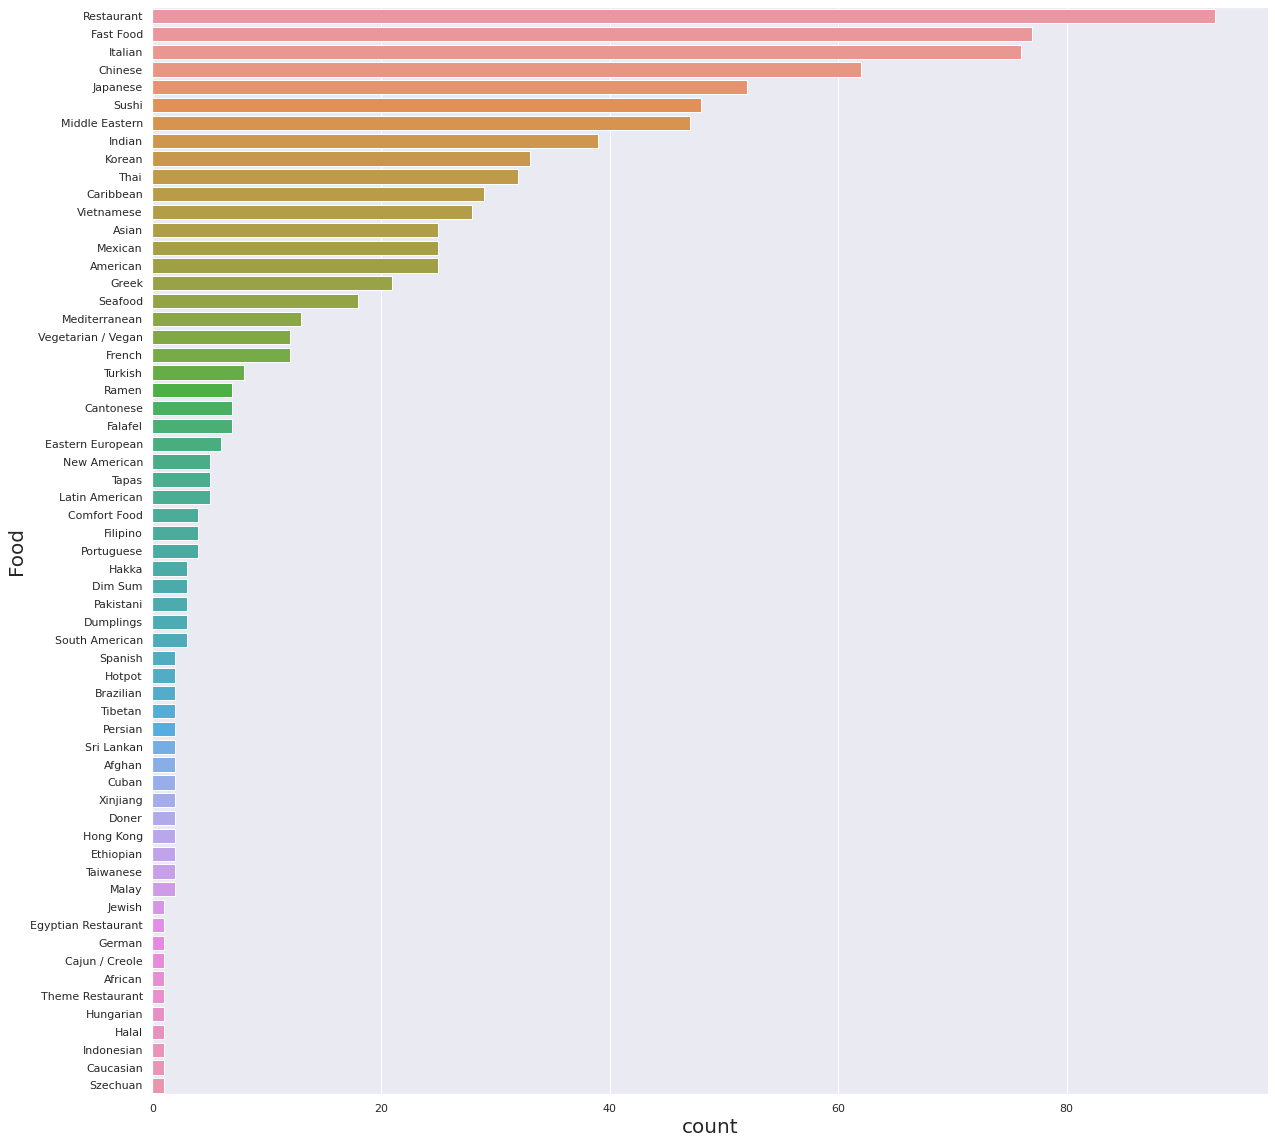

In [30]:
sns.set(rc = {"font.size":20, "axes.titlesize":20, "axes.labelsize":20, 'figure.figsize':(20,20)})
sns.countplot(y = "Food", data = restaurants_toronto, order = restaurants_toronto['Food'].value_counts().index)

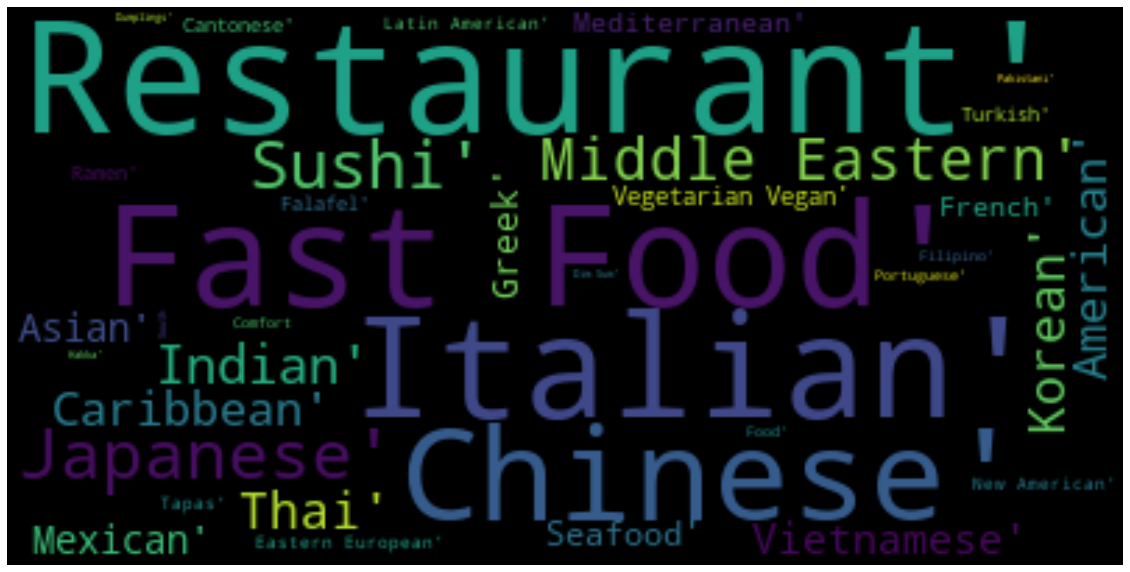

In [31]:
text = restaurants_toronto['Food'].values 

wordcloud = WordCloud().generate(str(text))

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

## Analize (Clustering)

In [32]:
K_clusters = range(1, 20)
kmeans = [KMeans(n_clusters = i) for i in K_clusters]
Y_axis = jap_restaurants_toronto[['Latitude']]
X_axis = jap_restaurants_toronto[['Longitude']]
distances = [kmeans[i].fit(Y_axis).score(Y_axis) for i in range(len(kmeans))]

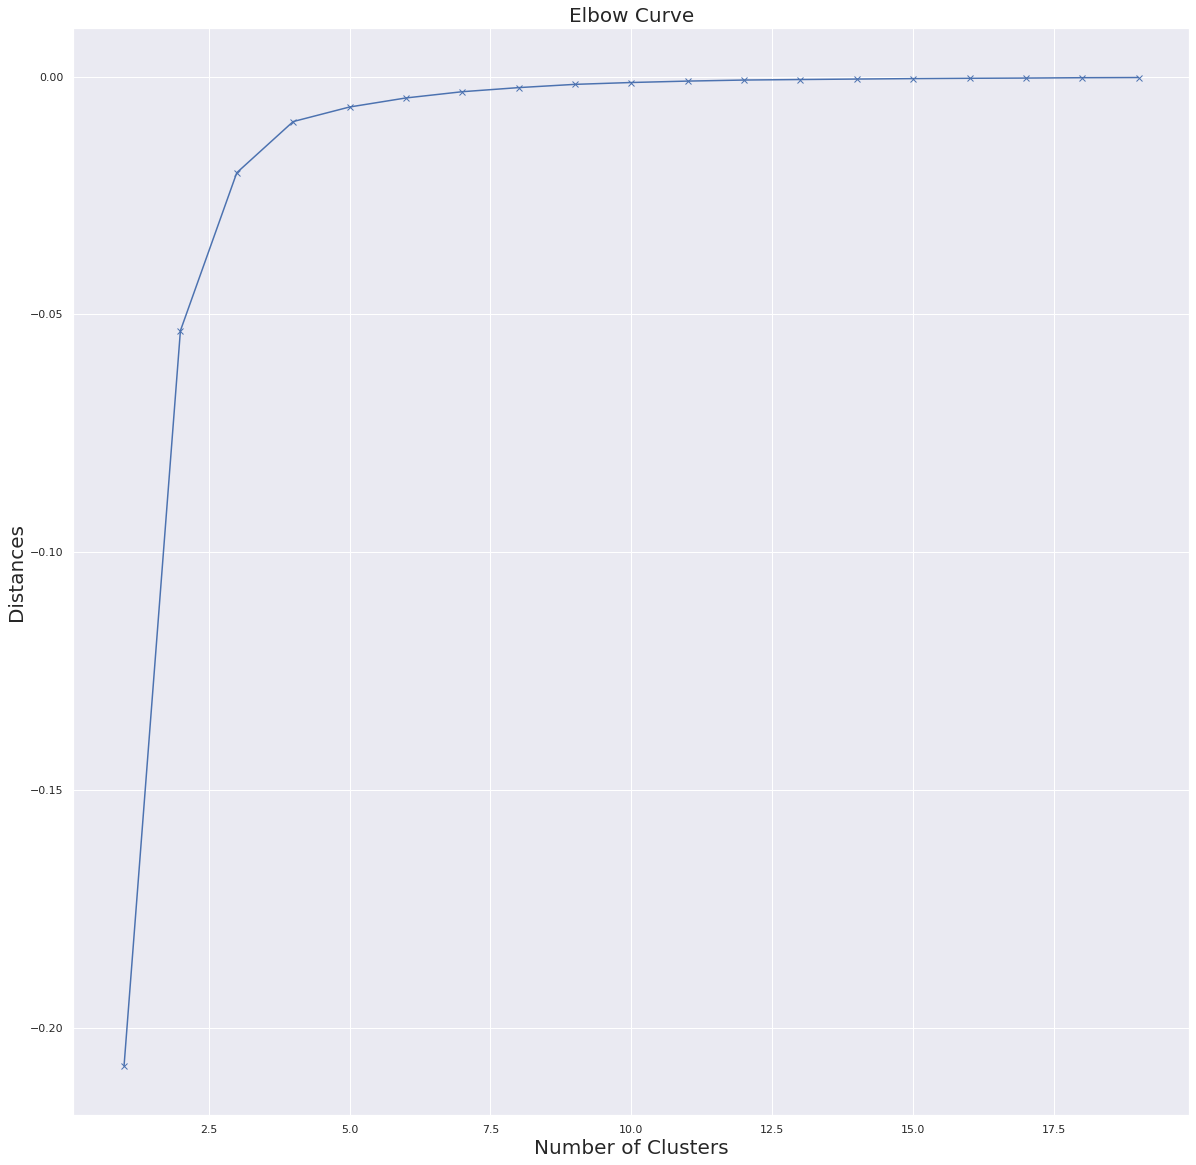

In [33]:
# Visualize
plt.plot(K_clusters, distances, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Distances')
plt.title('Elbow Curve')
plt.show()

In cluster analysis, the elbow method is a heuristic used in determining the number of clusters in a data set. The method consists of plotting the explained variation as a function of the number of clusters, and picking the elbow of the curve as the number of clusters to use. In our case approximately 3.0.

In [34]:
neighborhood_clustering = jap_restaurants_toronto[['Food','Latitude','Longitude','Neighborhood']]
kclusters = 3

kmeans = KMeans(n_clusters = kclusters, init ='k-means++')
kmeans.fit(neighborhood_clustering[neighborhood_clustering.columns[1:3]])
neighborhood_clustering['Cluster Label'] = kmeans.fit_predict(neighborhood_clustering[neighborhood_clustering.columns[1:3]])
centers = kmeans.cluster_centers_
labels = kmeans.predict(neighborhood_clustering[neighborhood_clustering.columns[1:3]])
neighborhood_clustering

,Food,Latitude,Longitude,Neighborhood,Cluster Label
0,Japanese,43.745494,-79.345821,Parkwoods,0
1,Japanese,43.755251,-79.360323,Parkwoods,0
2,Japanese,43.745737,-79.345991,Parkwoods,0
3,Japanese,43.720931,-79.337185,Victoria Village,0
4,Japanese,43.727006,-79.292946,Victoria Village,0
5,Japanese,43.651422,-79.375047,"Regent Park, Harbourfront",1
6,Japanese,43.663618,-79.370670,"Regent Park, Harbourfront",1
7,Japanese,43.641374,-79.377531,"Regent Park, Harbourfront",1
8,Japanese,43.646473,-79.378782,"Regent Park, Harbourfront",1
9,Japanese,43.647223,-79.379374,"Regent Park, Harbourfront",1


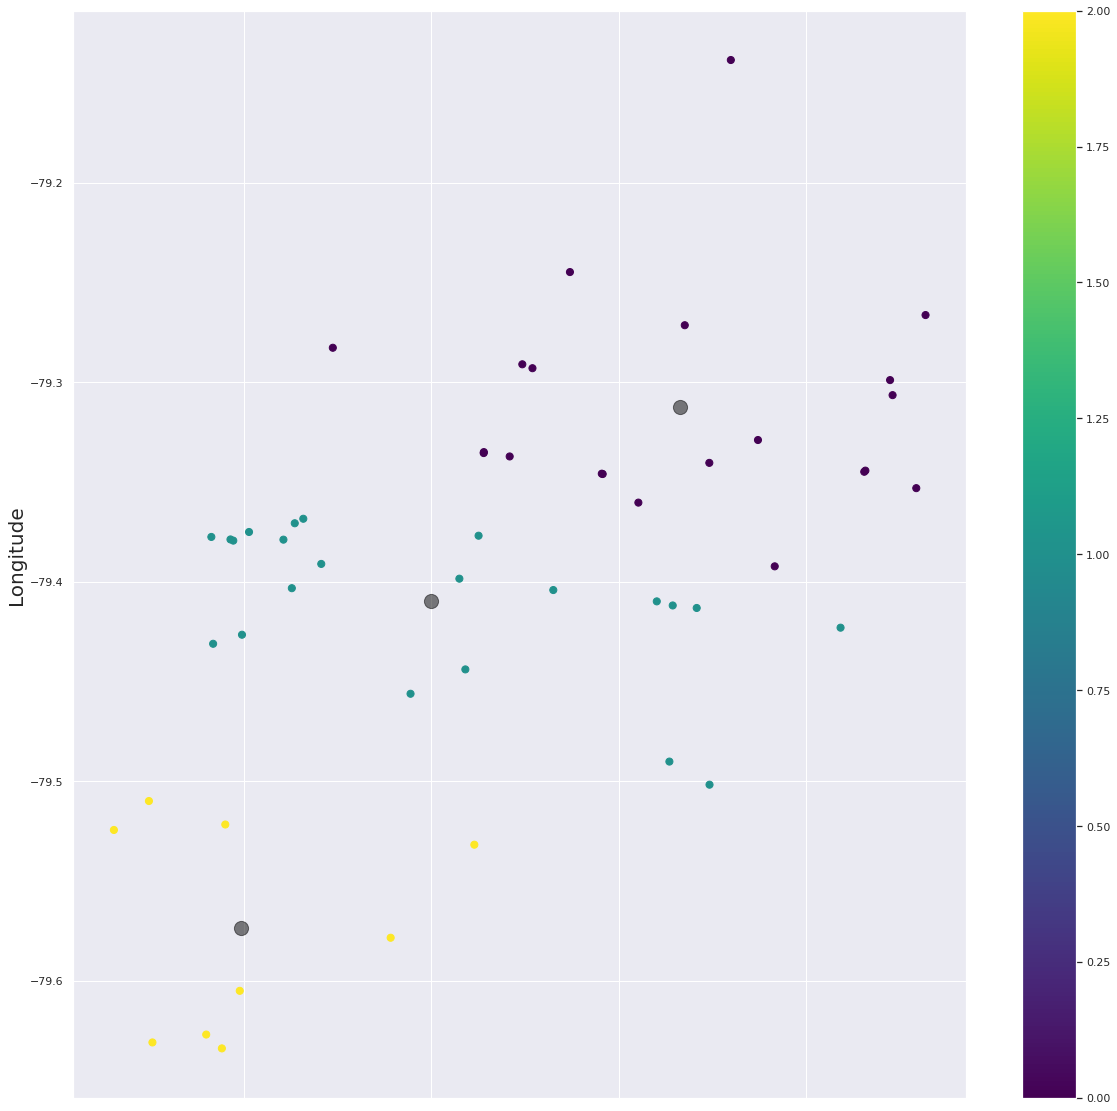

In [35]:
neighborhood_clustering.plot.scatter(x = 'Latitude', y = 'Longitude', c=labels, s = 50, cmap = 'viridis')
plt.scatter(centers[:, 0], centers[:, 1], c = 'black', s = 200, alpha = 0.5)

In [36]:
centers = kmeans.cluster_centers_
print(centers)

[[ 43.76647027 -79.31221634]
 [ 43.70000588 -79.40954201]
 [ 43.64941228 -79.57367326]]


In [37]:
neighborhood_clustering = neighborhood_clustering.sort_values(by='Cluster Label', ascending = True).reset_index(drop = True)
neighborhood_clustering

,Food,Latitude,Longitude,Neighborhood,Cluster Label
0,Japanese,43.745494,-79.345821,Parkwoods,0
1,Japanese,43.823043,-79.306446,"Milliken, Agincourt North, Steeles East, L'Amo...",0
2,Japanese,43.831832,-79.266304,"Milliken, Agincourt North, Steeles East, L'Amo...",0
3,Japanese,43.822372,-79.298905,"Milliken, Agincourt North, Steeles East, L'Amo...",0
4,Japanese,43.724299,-79.290987,"Kennedy Park, Ionview, East Birchmount Park",0
5,Japanese,43.774171,-79.340401,"Fairview, Henry Farm, Oriole",0
6,Japanese,43.787145,-79.328940,"Fairview, Henry Farm, Oriole",0
7,Japanese,43.737003,-79.244750,Scarborough Village,0
8,Japanese,43.714044,-79.335000,Thorncliffe Park,0
9,Japanese,43.791613,-79.392267,Hillcrest Village,0


In [39]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], tiles="cartodbpositron", zoom_start = 11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i * x) ** 2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

locations = neighborhood_clustering[['Latitude', 'Longitude']]
location_list = locations.values.tolist()

for i in range(0, len(location_list)):

    point_name = neighborhood_clustering['Food'][i]
    point_yard = neighborhood_clustering['Neighborhood'][i]
    point_cluster = neighborhood_clustering['Cluster Label'][i]
    point_detail = '<b>' + point_name + '</b><br /><i> Cluster ' + str(point_cluster) + ' in '  + point_yard + '</i>'

    folium.CircleMarker(
        location_list[i],
        radius = 5,
        popup = point_detail,
        color = rainbow[point_cluster - 1],
        fill = True,
        fill_color = rainbow[point_cluster - 1],
        fill_opacity = 0.7).add_to(map_clusters)
       
map_clusters

In [40]:
## Cluster 1 in neighborhood_merged
neighborhood_cluster1 = neighborhood_clustering[neighborhood_clustering['Cluster Label'] == 0]
neighborhood_cluster1

,Food,Latitude,Longitude,Neighborhood,Cluster Label
0,Japanese,43.745494,-79.345821,Parkwoods,0
1,Japanese,43.823043,-79.306446,"Milliken, Agincourt North, Steeles East, L'Amo...",0
2,Japanese,43.831832,-79.266304,"Milliken, Agincourt North, Steeles East, L'Amo...",0
3,Japanese,43.822372,-79.298905,"Milliken, Agincourt North, Steeles East, L'Amo...",0
4,Japanese,43.724299,-79.290987,"Kennedy Park, Ionview, East Birchmount Park",0
5,Japanese,43.774171,-79.340401,"Fairview, Henry Farm, Oriole",0
6,Japanese,43.787145,-79.328940,"Fairview, Henry Farm, Oriole",0
7,Japanese,43.737003,-79.244750,Scarborough Village,0
8,Japanese,43.714044,-79.335000,Thorncliffe Park,0
9,Japanese,43.791613,-79.392267,Hillcrest Village,0


In [41]:
## Cluster 2 in neighborhood_merged
neighborhood_cluster2 = neighborhood_clustering[neighborhood_clustering['Cluster Label'] == 1]
neighborhood_cluster2

,Food,Latitude,Longitude,Neighborhood,Cluster Label
21,Japanese,43.641846,-79.431086,"Little Portugal, Trinity",1
22,Japanese,43.670683,-79.391056,"Moore Park, Summerhill East",1
23,Japanese,43.712637,-79.376914,Lawrence Park,1
24,Japanese,43.774224,-79.501720,Downsview Northwest,1
25,Japanese,43.763523,-79.490136,Downsview Northwest,1
26,Japanese,43.732562,-79.404147,"Bedford Park, Lawrence Manor East",1
27,Japanese,43.809168,-79.423015,"Willowdale, Newtonbrook",1
28,Japanese,43.651422,-79.375047,"Regent Park, Harbourfront",1
29,Japanese,43.663618,-79.370670,"Regent Park, Harbourfront",1
30,Japanese,43.665895,-79.368415,Rosedale,1


In [42]:
## Cluster 3 in neighborhood_merged
neighborhood_cluster3 = neighborhood_clustering[neighborhood_clustering['Cluster Label'] == 2]
neighborhood_cluster3

,Food,Latitude,Longitude,Neighborhood,Cluster Label
43,Japanese,43.615389,-79.524415,"New Toronto, Mimico South, Humber Bay Shores",2
44,Japanese,43.648952,-79.605052,"Eringate, Bloordale Gardens, Old Burnhamthorpe...",2
45,Japanese,43.640005,-79.626960,Enclave of L4W,2
46,Japanese,43.625661,-79.630920,Enclave of L4W,2
47,Japanese,43.644181,-79.633899,Enclave of L4W,2
48,Japanese,43.711507,-79.531797,"Humberlea, Emery",2
49,Japanese,43.624728,-79.509904,"New Toronto, Mimico South, Humber Bay Shores",2
50,Japanese,43.689193,-79.578441,"Kingsview Village, St. Phillips, Martin Grove ...",2
51,Japanese,43.645094,-79.521672,Islington Avenue,2
